In [2]:
import pandas as pd
import numpy as np

# Read all the CSV files into datasets
df_job_postings = pd.read_csv("job_postings.csv")
df_company_industries = pd.read_csv("company_industries.csv")
df_companies = pd.read_csv("companies.csv")
df_company_specialities = pd.read_csv("company_specialities.csv")
df_benefits = pd.read_csv("benefits.csv") #Job benefits such as Medical insurance and Dental insurance, do we want to use this??
df_employee_counts = pd.read_csv("employee_counts.csv") #Linkedin information employee_count and follower_count, do we want to use this??
df_industries = pd.read_csv("industries.csv")  #Job_postings file included the industries already
df_job_industries = pd.read_csv("job_industries.csv") #Job_postings file included the industries already(This links with previous file)
df_job_skills = pd.read_csv("job_skills.csv")
df_skills = pd.read_csv("skills.csv")
df_salaries = pd.read_csv("salaries.csv")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 400)

In [3]:
#Pick out relavant data for our research and make a dataframe where all the infromation is linked to job_id

#Columns of interest from the job_postings csv file
df_job_postings_columns = ['job_id', 'company_id', 'title', 'skills_desc']
df_main = df_job_postings[df_job_postings_columns]
df_main.to_csv('main_dataframe.csv', index=False)
df_main = df_main.rename(columns={'title': 'job_title'})

#Columns of interest from company_industries file
df_main = pd.merge(df_main, df_company_industries[['company_id', 'industry']], on='company_id', how='left')

#Columns of interest from companies file
df_main = pd.merge(df_main, df_companies[['company_id', 'company_size','country']], on='company_id', how='left')

#Columns of interest from company_specialities file
df_main = pd.merge(df_main, df_company_specialities[['company_id', 'speciality']], on='company_id', how='left')
df_main = df_main.rename(columns={'speciality': 'company_speciality'})

#Columns of interest from job_skills file, changing the acronym to a word using the definitons of acronyms from skills file
df_main = pd.merge(df_main, df_job_skills[['job_id', 'skill_abr']], on='job_id', how='left')
df_main = pd.merge(df_main, df_skills, left_on='skill_abr', right_on='skill_abr', how='left')
df_main.drop(columns='skill_abr', inplace=True)
df_main = df_main.rename(columns={'skill_name': 'work_specialization'})

#Columns of interest from salaries file
df_main = pd.merge(df_main, df_salaries[['job_id', 'max_salary','med_salary','min_salary','pay_period','currency','compensation_type']], on='job_id', how='left')

#Changing the column order to better visualize the data
desired_column_order = ['job_id', 'company_id', 'country','industry', 'company_speciality', 'company_size', 'job_title', 'work_specialization', 'skills_desc', 'max_salary','med_salary','min_salary','pay_period','currency','compensation_type']
df_main = df_main[desired_column_order]
df_main.drop_duplicates(subset=['job_id'], keep='first', inplace=True, ignore_index=True)


In [4]:
# Creating a duplicate DataFrame for wage comparisons
df_main_wages = df_main.copy()  # Making a copy to retain the original data

# Dropping rows with NaN values in the 'compensation_type' column
df_main_wages.dropna(subset=['compensation_type'], inplace=True)

# Converting all salaries to hourly wages assuming 40 working hours per week, 172 hours in a month, and 2080 hours in a year
# Additionally, adjusting some listings to ensure comparability between max, min, and median salaries
# The equation used: (min_salary + max_salary) / 2 for listings without 'med_salary'
# Removing a row with a 'pay_period' value of 'ONCE'
df_main_wages.drop(df_main_wages[df_main_wages['pay_period'] == 'ONCE'].index, inplace=True)

hourly_conversion = {
    'HOURLY': 1,
    'YEARLY': 2080,
    'MONTHLY': 172,
    'WEEKLY': 40
}

def convert_to_hourly(row):
    conversion = row["pay_period"]

    if pd.notnull(row['med_salary']):
        hourly_rate = row['med_salary'] / hourly_conversion[conversion]
        row['average_hourly_rate'] = round(hourly_rate, 2)
    else:
        hourly_rate = (row['min_salary'] + row['max_salary']) / 2 / hourly_conversion[conversion]
        row['average_hourly_rate'] = round(hourly_rate, 2)

    return row

# Applying the function to create a new 'average_hourly_rate' column
df_main_wages['average_hourly_rate'] = df_main_wages.apply(convert_to_hourly, axis=1)['average_hourly_rate']

# Dropping unnecessary columns ('max_salary', 'min_salary', 'med_salary', 'compensation_type') from the new DataFrame
columns_to_drop = ["max_salary", "min_salary", "med_salary", "compensation_type"]
df_main_wages.drop(columns=columns_to_drop, inplace=True)

# Filtering outlier rows in df_main_wages with an average hourly rate above $400
outlier_row = df_main_wages[df_main_wages['average_hourly_rate'] > 400]

# Extracting unique job IDs from the outlier rows
outlier_job_ids = outlier_row['job_id'].unique()

# Filtering main DataFrame 'df_main' based on the outlier job IDs
combined_filtered = df_main[df_main['job_id'].isin(outlier_job_ids)]

# Merging and sorting df_main by 'average_hourly_rate' from df_main_wages for manual inspection
combined_filtered_sorted = combined_filtered.merge(df_main_wages[['job_id', 'average_hourly_rate']], on='job_id')
combined_filtered_sorted = combined_filtered_sorted.sort_values(by='average_hourly_rate', ascending=True)  # Manual inspection performed

# After manual inspection, identified illogical values; filtered outliers above $505 hourly rate
high_hourly_rate = df_main_wages[df_main_wages['average_hourly_rate'] > 505]

# Removed rows with an average hourly rate over $505 from the original DataFrame
df_main_wages.drop(high_hourly_rate.index, inplace=True)

In [5]:
# This cell is for visualizing the DataFrame
#df_main_wages["currency"].value_counts()
df_main_wages.head(100)

,job_id,company_id,country,industry,company_speciality,company_size,job_title,work_specialization,skills_desc,pay_period,currency,average_hourly_rate
0,3757940104,553718.0,US,Retail,Digital Hearing Instruments,5.0,Hearing Care Provider,Other,NaN,MONTHLY,USD,30.52
3,3757938018,18213359.0,US,Non-profit Organization Management,NaN,4.0,Cook,Management,NaN,HOURLY,USD,22.27
4,3757937095,437225.0,US,Retail,Vitamins,5.0,Principal Cloud Security Architect (Remote),Information Technology,NaN,YEARLY,USD,115.81
8,3757936097,18213359.0,US,Non-profit Organization Management,NaN,4.0,Dishwasher,Management,NaN,HOURLY,USD,19.30
11,3757935381,19181907.0,US,Market Research,Automotive Research,4.0,Insights Analyst - Auto Industry,Research,NaN,YEARLY,USD,29.33
19,3757935001,73013724.0,US,Financial Services,NaN,3.0,Sales Manager,Sales,NaN,YEARLY,USD,114.18
23,3757934423,18213359.0,US,Non-profit Organization Management,NaN,4.0,Custodian/Janitor,Management,NaN,HOURLY,USD,19.30
24,3757934347,10515052.0,CA,Motor Vehicle Manufacturing,NaN,6.0,Body Technician,Engineering,NaN,HOURLY,USD,25.00
27,3757934319,18391435.0,US,Staffing and Recruiting,talent search,NaN,Controls Engineer,Engineering,NaN,YEARLY,USD,65.14
28,3757934318,6577380.0,US,Retail Office Equipment,storage containers,2.0,CDL Class B Driver,Management,NaN,HOURLY,USD,26.00


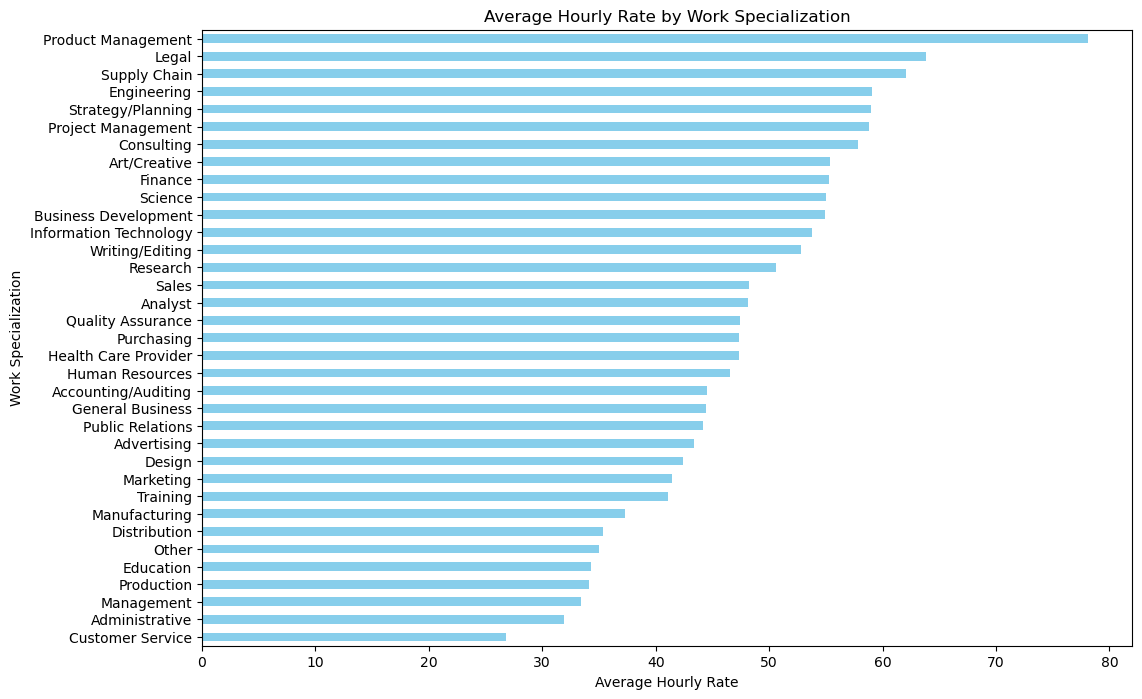

In [6]:
#Graph to see if there are discrepancys in hourly wages
import matplotlib.pyplot as plt

# Assuming df_main_wages is your DataFrame
# Grouping by 'industry' and calculating mean of 'average_hourly_rate'
industry_avg_rate = df_main_wages.groupby('work_specialization')['average_hourly_rate'].mean().sort_values()

# Plotting the graph
plt.figure(figsize=(12, 8))
industry_avg_rate.plot(kind='barh', color='skyblue')
plt.xlabel('Average Hourly Rate')
plt.ylabel('Work Specialization')
plt.title('Average Hourly Rate by Work Specialization')
plt.show()

In [10]:
df_main_wages.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13344 entries, 0 to 33245
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   job_id               13344 non-null  int64  
 1   company_id           13122 non-null  float64
 2   country              13108 non-null  object 
 3   industry             13097 non-null  object 
 4   company_speciality   10551 non-null  object 
 5   company_size         12442 non-null  float64
 6   job_title            13344 non-null  object 
 7   work_specialization  13049 non-null  object 
 8   skills_desc          105 non-null    object 
 9   pay_period           13344 non-null  object 
 10  currency             13344 non-null  object 
 11  average_hourly_rate  13344 non-null  float64
dtypes: float64(3), int64(1), object(8)
memory usage: 1.3+ MB
